In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pandas as pd
from skimage.exposure import match_histograms

sys.path.append(str(Path("..").resolve()))
from src import *

# PSNR and SSIM3D metrics

In [2]:
FRAMES = 600
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
y_path = DATASETS["synthetic"].dir / "deepcad_E_10_test.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, y, gt = (Recording(_, max_frames=FRAMES) for _ in [x_path, y_path, gt_path])
fft_fused = Recording(np.load("results/synthetic/fused_0.85_600_avg6000_mean.npy"))

In [3]:
voxel_xs = {
    "raw": x.np,
    "deep_cad": y.np,
    "fft": fft_fused.np,
}
voxel_y = gt.np

(0.0, 1000.0)

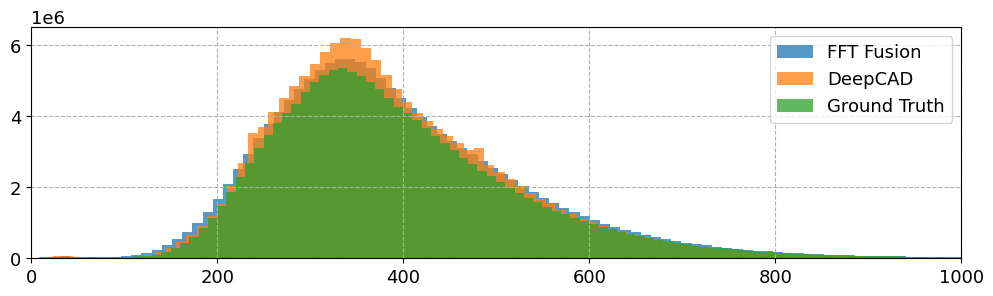

In [18]:
ax = pd.Series(voxel_xs["fft"].flatten()).hist(bins=2000, figsize=(12, 3), alpha=0.75, label="FFT Fusion")
pd.Series(voxel_xs["deep_cad"].flatten()).hist(bins=2000, ax=ax, alpha=0.75, label="DeepCAD");
pd.Series(voxel_y.flatten()).hist(bins=2000, ax=ax, alpha=0.75, label="Ground Truth");
ax.legend()
ax.set_xlim(0,1000)

In [71]:
voxel_xs["fft"] = match_histograms(voxel_xs["fft"], voxel_y)
voxel_xs["deep_cad"] = match_histograms(voxel_xs["deep_cad"], voxel_y)

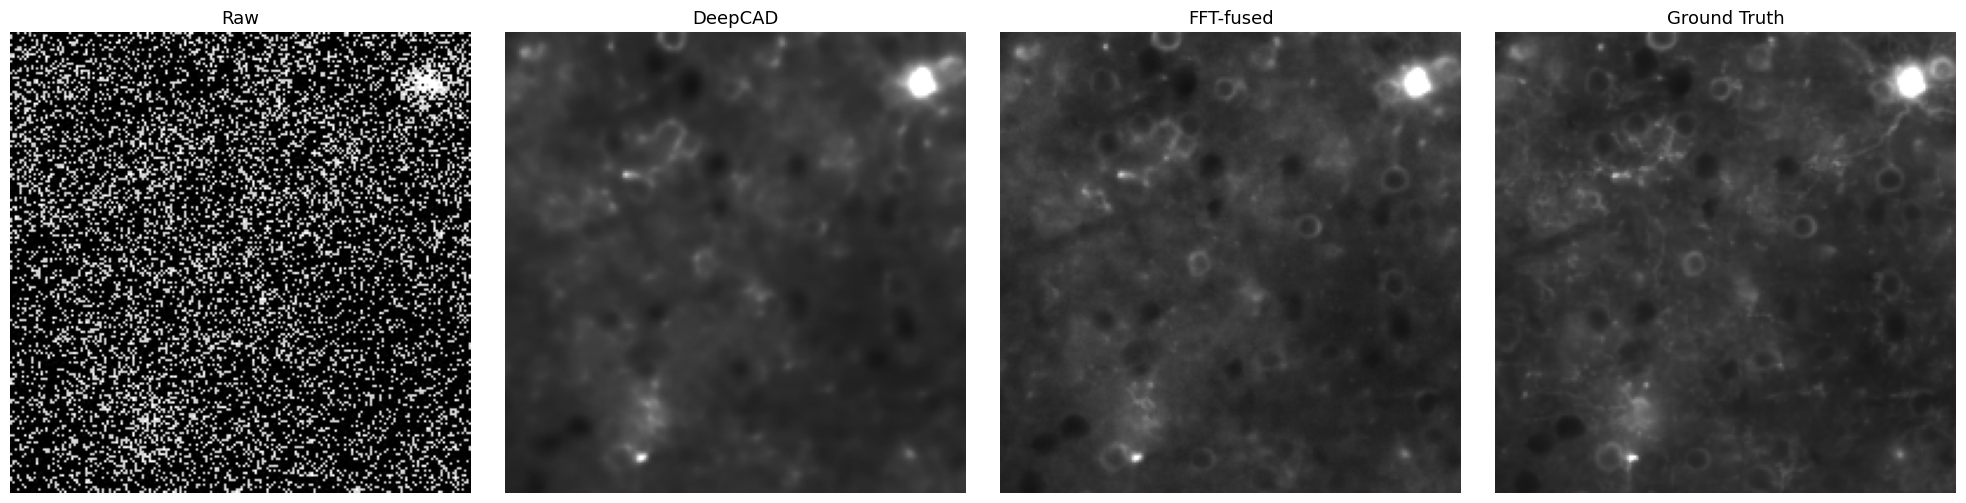

In [19]:
FRAME = 250
imshow(
    {
        "Raw": voxel_xs["raw"][FRAME],
        "DeepCAD": voxel_xs["deep_cad"][FRAME],
        "FFT-fused": voxel_xs["fft"][FRAME],
        "Ground Truth": voxel_y[FRAME],
    },
    size=5,
    zoom=2.5,
    vrange=(0,2000)
)

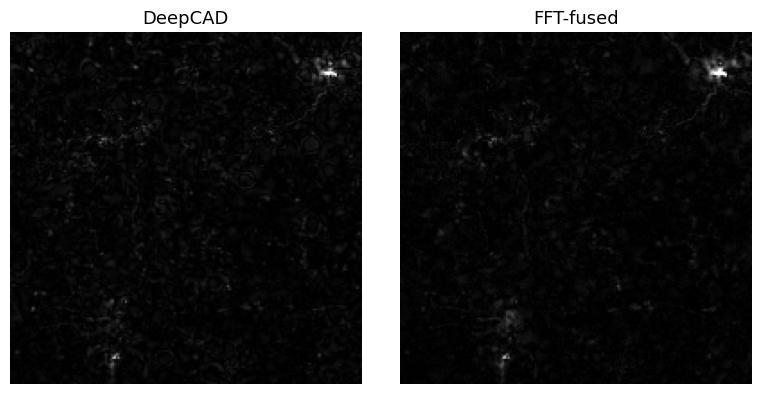

In [20]:
FRAME = 250
imshow(
    {
        "DeepCAD": np.abs(voxel_y[FRAME]-voxel_xs["deep_cad"][FRAME]),
        "FFT-fused": np.abs(voxel_y[FRAME]-voxel_xs["fft"][FRAME]),
        # "DeepCAD-": voxel_xs["deep_cad"][FRAME],
        # "FFT-fused-": voxel_xs["fft"][FRAME],
    },
    size=4,
    cols=2,
    zoom=2.5,
    vrange=(0,1000)
)

In [4]:
psnrs = {k: psnr3d(voxel_y, v, data_range=2_000) for k, v in tqdm(voxel_xs.items())}

for k, psnr in psnrs.items():
    cprint(f"PSNR with {k} =", f"green:{psnr:.2f}dB")

100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

PSNR with raw = 7.76dB
PSNR with deep_cad = 34.59dB
PSNR with fft = 35.79dB


In [ ]:
STEP=2
ssims = {k: ssim3d(voxel_y[::STEP], v[::STEP]) for k, v in tqdm(voxel_xs.items())}

for k, ssim in ssims.items():
    cprint(f"SSIM3D with {k} =", f"green:{ssim:.2f}")

SSIM3D comparison with different step values (higher `step` means faster computation, but more coarse SSIM3D):
|STEP|Raw|Deep_cad|FFT|
|:--:|--|--|--|
|`64`|0.23|0.91|0.92|
|`32`|0.15|0.82|0.84|
|`16`|0.10|0.78|0.82|
|`8`|0.08|0.81|0.85|
|`4`|0.06|0.82|0.87|
|`1`|0.06|0.83|0.88|

In [ ]:
ales = {k: ale(voxel_y, v) for k, v in tqdm(voxel_xs.items())}

for k, ales in ales.items():
    cprint(f"ALE with {k} =", f"green:{ales:.2f}")

100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

ALE with raw = 2663.94
ALE with deep_cad = 6.41
ALE with fft = 6.13


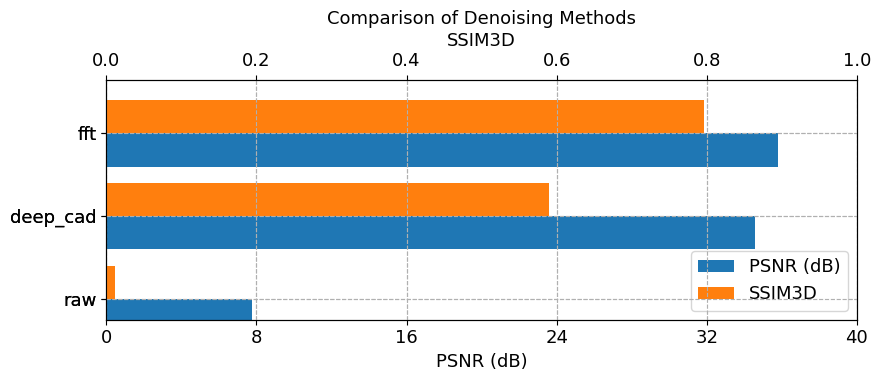

In [ ]:
df = pd.DataFrame({
    "PSNR (dB)": psnrs,
    "SSIM3D": ssims,
    "ALE": ales
})
fig, ax1 = plt.subplots(figsize=(9,4))

# plot PSNR
df["PSNR (dB)"].plot(kind="barh", ax=ax1, color="tab:blue", position=1, width=0.4, label="PSNR (dB)")
ax1.set_xlim(0,40)
ax1.set_xticks(range(0,41,8))
ax1.set_xlabel("PSNR (dB)")

ax2 = ax1.twiny()
df["SSIM3D"].plot(kind="barh", ax=ax2, color="tab:orange", position=0, width=0.4, label="SSIM3D")
ax2.set_xlim(0,1)
ax2.set_xlabel("SSIM3D")

ax1.set_yticks(range(len(df)))
ax1.set_yticklabels(df.index)
ax1.set_title("Comparison of Denoising Methods")

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="lower right")

plt.tight_layout()
plt.show()